# A Network Tour of Data Science, EPFL 2016
# Project: Facial Emotion Recognition
Dataset taken from: kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge
<br>
<br> Ref: "Challenges in Representation Learning: A report on three machine learning
contests." I Goodfellow, et al.
<br>
<br>
students: Patryk Oleniuk, Carmen Galotta



The project presented here is an algorithm to recognize and detect emotions from a face picture. 

Of course, the task of recognize face emotions is very easy for humans to do even if somethimes is really hard to understand how a person feels, but what can be easily understood thanks to human brain, is difficult to emulate by a machine.

The aim of this project is to classify faces in discrete human emotions. Due to the success of Convolutional Neural Network in images classification tasks it has been tought that employing it could be a good idea in face emotion as well.

The dataset has been taken from the kaggle competition and consists of 35k grey images with size 48x48 pixels already labeled with a number coding for classes of emotions, namely: 

0-Angry<br>
1-Disgust<br>
2-Fear<br>
3-Happy<br>
4-Sad<br>
5-Surprise<br>
6-Neutral<br>

The faces are mostly centered in the image.

# Configuration, dataset file

In [48]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy.misc
import time
import collections
import os
import utils as ut
import importlib
import copy

importlib.reload(ut)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# The CSV data (with removed first line ! (names))
emotions_dataset_dir = 'fer2013_full.csv'

#obtaining the number of line of the csv file
file = open(emotions_dataset_dir)
numline = len(file.readlines())
print ('Number of data in the dataset:',numline)

Number of data in the dataset: 35887


# Load the data from *.csv file 
The first step is to load the data from the .csv file. <br> The  format of the csv line is<br>
class{0,1,2,3,4,5,6},pix0 pix2304,DataUsage(not used)<br>
e.g.<br>
2,234 1 34 23 ..... 234 256 0,Training<br>
The picture is always 48x48 pixels, 0-255 greyscale.

# Data cleaning:
## 1.Remove strange data
In the database there are some images thar are not good (e.g. some images are pixelated, unrelevant, from animations).
It has been tried to filter them by looking at the maximum of the histogram. If the image is very homogenous, the maximum value of the histogram will be very high (that is to say above a certain threshold) then this image is filtered out. Of course in this way are also removed some relevant information, but it's better for the CNN not to consider these images.
## 2.Merge class 0 and 1
We discovered that class 1 has a very small amount of occurance in the test data et. This class, (disgust) is very similar to anger and that is why we merger class 0 and 1 together.
Therefore, the recognized emotions and labels are reduced to 6:<br>
0-(Angry + Disgust)<br>
1-Fear<br>
2-Happy<br>
3-Sad<br>
4-Surprise<br>
5-Neutral<br>

In [2]:
#Load the file in csv
ifile  = open(emotions_dataset_dir, "rt")
reader = csv.reader(ifile)

hist_threshold = 350 # images above this threshold will be removed
hist_div = 100 #parameter of the histogram

print('Loading Images. It may take a while, depending on the database size.')
images, emotions, strange_im, num_strange, num_skipped = ut.load_dataset(reader, numline, hist_div, hist_threshold)

ifile.close()

print('Skipped', num_skipped, 'happy class images.')
print(str( len(images) ) + ' are left after \'strange images\' removal.')
print('Deleted ' + str( num_strange ) + ' strange images. Images are shown below')


Loading Images. It may take a while, depending on the database size.
loaded  1% of dataset (529/35858). Filtered images: 29
loaded  3% of dataset (1051/35836). Filtered images: 51
loaded  4% of dataset (1572/35815). Filtered images: 72
loaded  6% of dataset (2097/35790). Filtered images: 97
loaded  7% of dataset (2627/35760). Filtered images: 127
loaded  8% of dataset (3157/35730). Filtered images: 157
loaded 10% of dataset (3674/35713). Filtered images: 174
loaded 11% of dataset (4189/35698). Filtered images: 189
loaded 13% of dataset (4720/35667). Filtered images: 220
loaded 14% of dataset (5250/35637). Filtered images: 250
loaded 15% of dataset (5783/35604). Filtered images: 283
loaded 17% of dataset (6315/35572). Filtered images: 315
loaded 18% of dataset (6834/35553). Filtered images: 334
loaded 20% of dataset (7367/35520). Filtered images: 367
loaded 21% of dataset (7896/35491). Filtered images: 396
loaded 23% of dataset (8422/35465). Filtered images: 422
loaded 24% of dataset (8

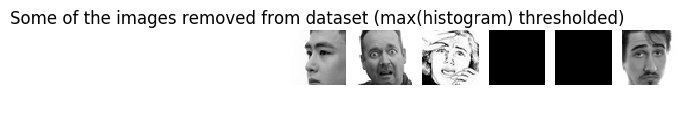

In [18]:
# showing strange images
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
idxs = np.random.choice(range(1,num_strange ), 6, replace=False)
for i, idx in enumerate(idxs):
    plt_idx = i
    plt.subplot(1, 6, plt_idx+1)
    plt.imshow(strange_im[idx])
    plt.axis('off')
    if(i == 0):
        plt.title('Some of the images removed from dataset (max(histogram) thresholded)')
plt.show()

# Explore the correct data
Here random pictures from each class are shown. As we can see some of them are with glasses or covered with long hair as well as some pictures taken from sideways. This is, of course, an additional challenge when training the neural network. 

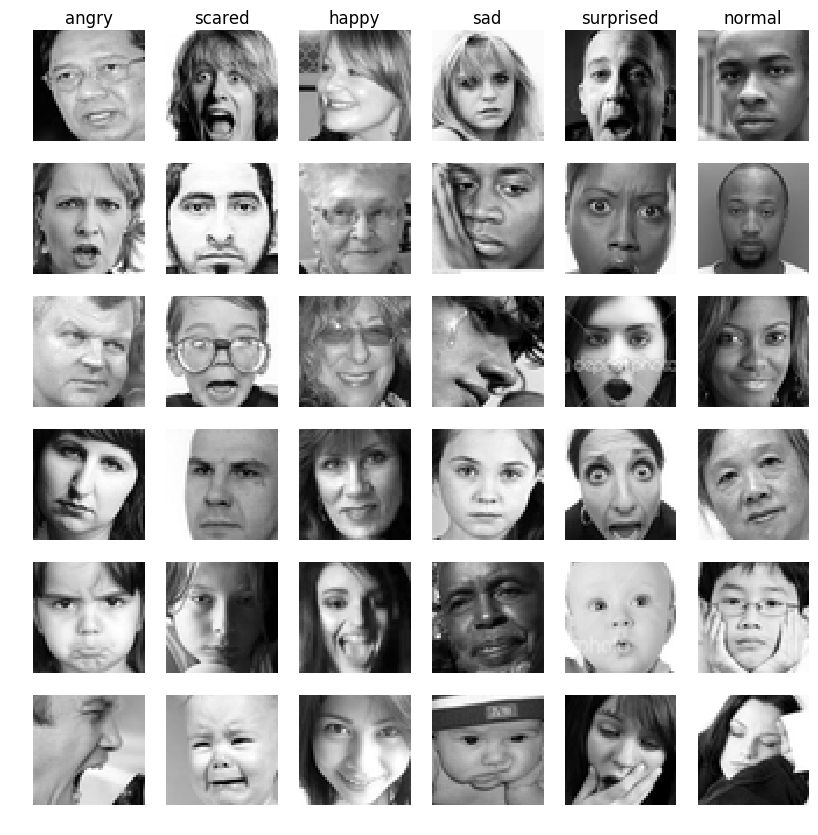

In [19]:
classes = [0,1,2,3,4,5]
str_emotions = ['angry','scared','happy','sad','surprised','normal']
num_classes = len(classes)
samples_per_class = 6
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(emotions == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx])
        y_h, x_h = np.histogram( images[idx], hist_div );
        plt.axis('off')
        if(i == 0):
            plt.title(str_emotions[y] )
plt.show()

# Prepare the Data for CNN
Here the initial data have been divided to create train and test data. <br>
This two subsets have both an associated label to train the neural network and to test its accuracy with the test data.
The number of images used for each category of emotions is shown both for the train as for the test data.<br>
The size of each batch it has been chosen to 64 because, after analyzing the performances, we discovered that decreasing the batch size from 100 to 64 actually improved the accuracy.

In [20]:
print('number of clean data:' + str(images.shape[0]) + '  48x48 pix , 0-255 greyscale images')
n_all = images.shape[0];
n_train = 64; # number of data for training and for batch

# dividing the input data
train_data_orig = images[0:n_all-n_train,:,:]
train_labels = emotions[0:n_all-n_train]
test_data_orig = images[n_all-n_train:n_all,:,:]
test_labels = emotions[n_all-n_train:n_all]

# Convert to float
train_data_orig = train_data_orig.astype('float32')
y_train = train_labels.astype('float32')
test_data_orig = test_data_orig.astype('float32')
y_test = test_labels.astype('float32')

print('orig train data ' + str(train_data_orig.shape))
print('orig train labels ' + str(train_labels.shape) + 'from ' + str(train_labels.min()) + ' to ' + str(train_labels.max()) )
print('orig test data ' + str(test_data_orig.shape))
print('orig test labels ' + str(test_labels.shape)+ 'from ' + str(test_labels.min()) + ' to ' + str(test_labels.max()) )

for i in range (0, 6):  
    print('TRAIN: number of' , i, 'labels',len(train_labels[train_labels == i]))

for i in range (0, 6):  
    print('TEST: number of', i, 'labels',len(test_labels[test_labels == i]))

number of clean data:31196  48x48 pix , 0-255 greyscale images
orig train data (31132, 48, 48)
orig train labels (31132,)from 0.0 to 5.0
orig test data (64, 48, 48)
orig test labels (64,)from 0.0 to 5.0
TRAIN: number of 0 labels 5134
TRAIN: number of 1 labels 4829
TRAIN: number of 2 labels 5789
TRAIN: number of 3 labels 5765
TRAIN: number of 4 labels 3739
TRAIN: number of 5 labels 5876
TEST: number of 0 labels 13
TEST: number of 1 labels 12
TEST: number of 2 labels 10
TEST: number of 3 labels 7
TEST: number of 4 labels 13
TEST: number of 5 labels 9


# Data Amount per class
As we can see, the number of training images for each class is different. For the initial database, the amount of "happy" images was even bigger(8k), that is why we decided to skip 3k random "happy" class images. This also helps with the speed of execution, since our database it's a bit smaller.<br>
In fact, the non homogeneous number of images per class could lead the network to be excessively accurate on one single class rather than on each one.

# Prepare the data for CNN
Here the data is modified  a little bit to be correctly fed into the CNN. <br>
What has been done is convert, normalize and subtract the const mean value from the data images.<br>
Finally the label values of the classes are converted to a binary one_hot vector.


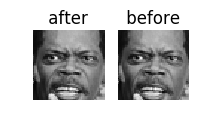

In [30]:
# Data pre-processing
n = train_data_orig.shape[0];
train_data = np.zeros([n,48**2])
for i in range(n):
    xx = train_data_orig[i,:,:]
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    train_data[i,:] = xx.reshape(2304); #np.reshape(xx,[-1])

n = test_data_orig.shape[0]
test_data = np.zeros([n,48**2])
for i in range(n):
    xx = test_data_orig[i,:,:]
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    test_data[i] = np.reshape(xx,[-1])

#print(train_data.shape)
#print(test_data.shape)
#print(train_data_orig[0][2][2])
#print(test_data[0][2])
plt.rcParams['figure.figsize'] = (2.0, 2.0) # set default size of plots
plt.subplot(121);
plt.imshow(train_data[9].reshape([48,48]));
plt.title(' after ');
plt.axis('off')
plt.subplot(122);
plt.imshow(train_data_orig[9]);
plt.title(' before ');
plt.axis('off');

In [31]:
# Convert label values to one_hot vector

train_labels = ut.convert_to_one_hot(train_labels,num_classes)
test_labels = ut.convert_to_one_hot(test_labels,num_classes)

print('train labels shape',train_labels.shape)
print('test labels shape',test_labels.shape)

train labels shape (31132, 6)
test labels shape (64, 6)


# Model 1 
In the first model it has been implemented a baseline softmax classifier using a single convolutional layer and a one fully connected layer. For the initial baseline
it has not be used any regularization, dropout, or batch normalization.

The equation of the classifier is simply:


$$
y=\textrm{softmax}(ReLU( x \ast W_1+b_1)W_2+b_2) 
$$

For this first attempt have been applied 64 filters with size 8x8.  
The optimization scheme chosen if the AdamOptimizer with a learning rate of 0.004 s.

In [46]:
# Define computational graph (CG)
batch_size = n_train    # batch size
d = train_data.shape[1]  # data dimensionality
nc = 6                  # number of classes

# Inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); 
y_label = tf.placeholder(tf.float32,[batch_size,nc]); 

#Size and number of filters
K0 = 8   # size of the patch
F0 = 64  # number of filters
ncl0 = K0*K0*F0

Wcl0 = tf.Variable(tf.truncated_normal([K0,K0,1,F0], stddev=tf.sqrt(2./tf.to_float(ncl0)) )); print('Wcl=',Wcl0.get_shape())
bcl0 = bias_variable([F0]); print('bcl0=',bcl0.get_shape()) #in ReLu case, small positive bias added to prevent killing of gradient when input is negative.

#Reshaping the input to size 48x48 
x_2d0 = tf.reshape(xin, [-1,48,48,1]); print('x_2d=',x_2d0.get_shape())

# Convolutional layer
x = tf.nn.conv2d(x_2d0, Wcl0, strides=[1, 1, 1, 1], padding='SAME')
x += bcl0; print('x2=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)

# Fully Connected layer
nfc = 48*48*F0
x = tf.reshape(x, [batch_size,-1]); print('x3=',x.get_shape())
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(2./tf.to_float(nfc+nc)) )); print('Wfc=',Wfc.get_shape())
bfc = tf.Variable(tf.zeros([nc])); print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); print('y1=',y.get_shape())
y += bfc; print('y2=',y.get_shape())

# Softmax
y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
train_step = tf.train.AdamOptimizer(0.004).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Wcl= (8, 8, 1, 64)
bcl0= (64,)
x_2d= (64, 48, 48, 1)
x2= (64, 48, 48, 64)
x3= (64, 147456)
Wfc= (147456, 6)
bfc= (6,)
y1= (64, 6)
y2= (64, 6)
y3(SOFTMAX)= (64, 6)


In [47]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(1001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for vao to increase the test acriable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%100:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.109375 , loss= 1.7942
test accuracy= 0.140625

Iteration i= 100 , train accuracy= 0.234375 , loss= 1.71757
test accuracy= 0.203125

Iteration i= 200 , train accuracy= 0.359375 , loss= 1.66261
test accuracy= 0.3125

Iteration i= 300 , train accuracy= 0.40625 , loss= 1.55144
test accuracy= 0.25

Iteration i= 400 , train accuracy= 0.4375 , loss= 1.44691
test accuracy= 0.234375

Iteration i= 500 , train accuracy= 0.265625 , loss= 1.59834
test accuracy= 0.296875

Iteration i= 600 , train accuracy= 0.28125 , loss= 1.72735
test accuracy= 0.265625

Iteration i= 700 , train accuracy= 0.328125 , loss= 1.61648
test accuracy= 0.265625

Iteration i= 800 , train accuracy= 0.40625 , loss= 1.49183
test accuracy= 0.25

Iteration i= 900 , train accuracy= 0.421875 , loss= 1.48842
test accuracy= 0.28125

Iteration i= 1000 , train accuracy= 0.4375 , loss= 1.36199
test accuracy= 0.203125


# Comments
The model was overfitting the shortened (1200) data, while getting a test accuracy of only 28%. For the full dataset of 35k images the dataset was not diverging (shown above) and the accuracy was also around 25%. It could not find any features with this architecture. That is why we discarded Model 1 and started to implement more advanced architectures.

In order to prevent overfitting in the following models have been applied different techniques such as dropout and pool, as well as tried to implement a neural network of more layers. 

This should help and improve the model since the first convolutional layer will just extract some simplest characteristics of the image such as edges, lines and curves. Adding layers will improve the performances because they will detect some high level feature which in this case could be really relevant since it's about face expressions.

# Techniques 

To prevent the overfitting problem observed with the first model as well as extract as many features as possible from the images, the following techniques have been studied and used.

## 1.Choosing Hyperparameters

One of the most challenging choise to be done while constructing a convolutional neural network is the choice of the number and dimension of the filter to be used as well as the number of layers to employ.<br>
Of course there is not a standard design, because it depends on the dataset and the features of the different images and on the complexity of the task.
For our purpose we decided to start with a higher size of filter and then decrease it.

Besides, the activation layer that has been employed is the ReLU one (Rectified Linear Units) which is the most used and most efficient since it helps to alleviate the vanishing gradient problem.
The ReLU layer applies the non linear function f(x) = max(0, x) to the input basically just eliminating all the negative activations. 
This design choice also explain why we initialized the bias vector b to a small positive value that is to prevent killing of gradient when input is negative.

## 2.Pooling Layers

Pool layer could be added after the ReLu ones. This layer is also known as a downsampling layer.
The intuitive reasoning behind this layer is that once we know that a specific feature is in the original input volume, its exact location is not as important as its relative location to the other features.
This layer drastically reduces the spatial dimensions of the input volume and is used to reduce the computation cost and to control overfitting.

## 3.Dropout Layers
Finally, dropout layers can be used to deactivate with a defined probability a random set of activations in that specific layer which in the forward pass is then considered as set to zero.
Also this technique can help to prevent the overfitting problem. 

Ref: https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/

# Advanced computational graphs - functions

In [33]:
#Definition of function that have been used in the CNN

d = train_data.shape[1]

def weight_variable2(shape, nc10):
        initial2 = tf.random_normal(shape, stddev=tf.sqrt(2./tf.to_float(ncl0)) )
        return tf.Variable(initial2)
    
def conv2dstride2(x,W):
        return tf.nn.conv2d(x,W,strides=[1, 2, 2, 1], padding='SAME')

def conv2d(x,W):
        return tf.nn.conv2d(x,W,strides=[1, 1, 1, 1], padding='SAME')
    
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=1/np.sqrt(d/2) )
        return tf.Variable(initial)
    
def bias_variable(shape):
    initial = tf.constant(0.01,shape=shape)
    return tf.Variable(initial)

# Different architectures
During our research we tried different architectures and tested numerous techniqies to achieve the best possible results. Among others, we experimented with:
<br> - 2 to 10 convolutional layers 
<br> - 1 to 4 fully connected layers in different places in the graph (middle, end, beggining)
<br> - different size of patches (from 2 to 16) and filters(from 10 to 64)
<br> - max pooling
<br> - droupout
<br> - L2 regularization

# Model 2:  7 Layers, Conv-Relu-Maxpool, 1 Fully Connected 

The third model consists in a 6 layer convolutional neural network with a final fully connected layer.

$$
x= maxpool2x2( ReLU( ReLU( x* W_1+b_1) * W_2+b_2))$$ 3 times (also for $W_3,b_3 W_4,b_4 W_4,b_4 W_5,b_5 W_6,b_6$) 

for each layer it has been added a pool layer after the ReLU and this result in a decreasing dimensionality (from 48 to 6)

$$
y=\textrm{softmax} {( x W_{norm6}+b_{norm6})}$$

For the 1,2,3 layers the filter used are 22 with a dimension of 8x8 while for the 4,5,6 a dimension of 4x4.
A dropout layer is also applied.
The optimization scheme used it AdamOptimizer with a learning rate of 0.001 s. The dropout probability has been set to 0.5.

In [36]:
tf.reset_default_graph()

# implementation of Conv-Relu-COVN-RELU - pool
# based on : http://cs231n.github.io/convolutional-networks/

# Define computational graph (CG)
batch_size = n_train    # batch size
d = train_data.shape[1]  # data dimensionality
nc = 6                  # number of classes

# Inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())


#for the first conc-conv
# Convolutional layer
K0 = 8   # size of the patch
F0 = 22  # number of filters
ncl0 = K0*K0*F0

#for the second conc-conv
K1 = 4   # size of the patch
F1 = F0  # number of filters
ncl1 = K1*K1*F1

#drouput probability
keep_prob_input=tf.placeholder(tf.float32)

#1st set of conv followed by conv2d operation and dropout 0.5
W_conv1=weight_variable([K0,K0,1,F0]); print('W_conv1=',W_conv1.get_shape())
b_conv1=bias_variable([F0]); print('b_conv1=',b_conv1.get_shape())
x_2d1 = tf.reshape(xin, [-1,48,48,1]); print('x_2d1=',x_2d1.get_shape())

#conv2d 
h_conv1=tf.nn.relu(conv2d(x_2d1, W_conv1) + b_conv1); print('h_conv1=',h_conv1.get_shape())
#h_conv1= tf.nn.dropout(h_conv1,keep_prob_input);

# 2nd convolutional layer + max pooling
W_conv2=weight_variable([K0,K0,F0,F0]); print('W_conv2=',W_conv2.get_shape())
b_conv2=bias_variable([F0]); print('b_conv2=',b_conv2.get_shape())

# conv2d + max pool
h_conv2 = tf.nn.relu(conv2d(h_conv1,W_conv2)+b_conv2); print('h_conv2=',h_conv2.get_shape())
h_conv2_pooled = max_pool_2x2(h_conv2); print('h_conv2_pooled=',h_conv2_pooled.get_shape())

#3rd set of conv 
W_conv3=weight_variable([K0,K0,F0,F0]); print('W_conv3=',W_conv3.get_shape())
b_conv3=bias_variable([F1]); print('b_conv3=',b_conv3.get_shape())
x_2d3 = tf.reshape(h_conv2_pooled, [-1,24,24,F0]); print('x_2d3=',x_2d3.get_shape())

#conv2d
h_conv3=tf.nn.relu(conv2d(x_2d3, W_conv3) + b_conv3); print('h_conv3=',h_conv3.get_shape())

# 4th convolutional layer 
W_conv4=weight_variable([K1,K1,F1,F1]); print('W_conv4=',W_conv4.get_shape())
b_conv4=bias_variable([F1]); print('b_conv4=',b_conv4.get_shape())

#conv2d + max pool 4x4
h_conv4 = tf.nn.relu(conv2d(h_conv3,W_conv4)+b_conv4); print('h_conv4=',h_conv4.get_shape())
h_conv4_pooled = max_pool_2x2(h_conv4); print('h_conv4_pooled=',h_conv4_pooled.get_shape())
h_conv4_pooled = max_pool_2x2(h_conv4_pooled); print('h_conv4_pooled=',h_conv4_pooled.get_shape())

#5th set of conv 
W_conv5=weight_variable([K1,K1,F1,F1]); print('W_conv5=',W_conv5.get_shape())
b_conv5=bias_variable([F1]); print('b_conv5=',b_conv5.get_shape())
x_2d5 = tf.reshape(h_conv4_pooled, [-1,6,6,F1]); print('x_2d5=',x_2d5.get_shape())

#conv2d
h_conv5=tf.nn.relu(conv2d(x_2d5, W_conv5) + b_conv5); print('h_conv5=',h_conv5.get_shape())

# 6th convolutional layer 
W_conv6=weight_variable([K1,K1,F1,F1]); print('W_con6=',W_conv6.get_shape())
b_conv6=bias_variable([F1]); print('b_conv6=',b_conv6.get_shape())
b_conv6= tf.nn.dropout(b_conv6,keep_prob_input);

#conv2d + max pool 4x4
h_conv6 = tf.nn.relu(conv2d(h_conv5,W_conv6)+b_conv6); print('h_conv6=',h_conv6.get_shape())
h_conv6_pooled = max_pool_2x2(h_conv6); print('h_conv6_pooled=',h_conv6_pooled.get_shape())

# reshaping for fully connected
h_conv6_pooled_rs = tf.reshape(h_conv6, [batch_size,-1]); print('x2_rs',h_conv6_pooled_rs.get_shape());
W_norm6 = weight_variable([  6*6*F1, nc]); print('W_norm6=',W_norm6.get_shape())
b_norm6 = bias_variable([nc]); print('b_conv6=',b_norm6.get_shape())

# fully connected layer
h_full6 = tf.matmul( h_conv6_pooled_rs, W_norm6 ); print('h_full6=',h_full6.get_shape())
h_full6 += b_norm6; print('h_full6=',h_full6.get_shape())

y = h_full6; 

## Softmax
y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

W_conv1= (8, 8, 1, 22)
b_conv1= (22,)
x_2d1= (64, 48, 48, 1)
h_conv1= (64, 48, 48, 22)
W_conv2= (8, 8, 22, 22)
b_conv2= (22,)
h_conv2= (64, 48, 48, 22)
h_conv2_pooled= (64, 24, 24, 22)
W_conv3= (8, 8, 22, 22)
b_conv3= (22,)
x_2d3= (64, 24, 24, 22)
h_conv3= (64, 24, 24, 22)
W_conv4= (4, 4, 22, 22)
b_conv4= (22,)
h_conv4= (64, 24, 24, 22)
h_conv4_pooled= (64, 12, 12, 22)
h_conv4_pooled= (64, 6, 6, 22)
W_conv5= (4, 4, 22, 22)
b_conv5= (22,)
x_2d5= (64, 6, 6, 22)
h_conv5= (64, 6, 6, 22)
W_con6= (4, 4, 22, 22)
b_conv6= (22,)
h_conv6= (64, 6, 6, 22)
h_conv6_pooled= (64, 3, 3, 22)
x2_rs (64, 792)
W_norm6= (792, 6)
b_conv6= (6,)
h_full6= (64, 6)
h_full6= (64, 6)
y3(SOFTMAX)= (64, 6)


In [239]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(20001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for vao to increase the test acriable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y, keep_prob_input: 0.5})
    
    # Run CG for test set
    if not i%100:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict = {xin: test_data, y_label: test_labels, keep_prob_input: 1.0})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.140625 , loss= 1.79194
test accuracy= 0.125

Iteration i= 100 , train accuracy= 0.15625 , loss= 1.78374
test accuracy= 0.140625

Iteration i= 200 , train accuracy= 0.21875 , loss= 1.7552
test accuracy= 0.140625

Iteration i= 300 , train accuracy= 0.1875 , loss= 1.7827
test accuracy= 0.109375

Iteration i= 400 , train accuracy= 0.265625 , loss= 1.74103
test accuracy= 0.109375

Iteration i= 500 , train accuracy= 0.28125 , loss= 1.56178
test accuracy= 0.25

Iteration i= 600 , train accuracy= 0.46875 , loss= 1.48862
test accuracy= 0.203125

Iteration i= 700 , train accuracy= 0.265625 , loss= 1.61876
test accuracy= 0.171875

Iteration i= 800 , train accuracy= 0.328125 , loss= 1.54113
test accuracy= 0.234375

Iteration i= 900 , train accuracy= 0.421875 , loss= 1.46915
test accuracy= 0.328125

Iteration i= 1000 , train accuracy= 0.5 , loss= 1.41078
test accuracy= 0.25

Iteration i= 1100 , train accuracy= 0.53125 , loss= 1.39398
test accuracy= 0.265625

Iter

# Model 2- Results

This second model reaches a test accuracy up to 56% which is the best result we could get.
We can also see that we have prevented the overfitting problem observed with the previous models.

# Saving the trained graph in TF file
Ref:https://www.tensorflow.org/how_tos/variables/

In [ ]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Save the variables to disk.
save_path = saver.save(sess, "model_6layers.ckpt")
print("Model saved in file: %s" % save_path)

# Reading Model from TF File
Ref:https://www.tensorflow.org/how_tos/variables/

In [38]:
sess = tf.Session()
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

saver.restore(sess, "model_6layers.ckpt")

# Class Accuracy

To see how our network behaves for every classes, it is calculated separately the accuracy for each of them.<br>
As we can see it is slightly different for each emotion, with a highest accuracy for the surprised one (72%) and a lowest for the sad one (31%).

In [39]:
# calculating accuracy for each class separately for the test set
result_cnn = sess.run([y], feed_dict = {xin: test_data,  keep_prob_input: 1.0})
#result = sess.run(y, feed_dict={xin: test_data, keep_prob_input: 1.0})

tset = test_labels.argmax(1);
result = np.asarray(result_cnn[:][0]).argmax(1);

for i in range (0,nc):
    print('accuracy',str_emotions[i]+str('   '), '\t',ut.calc_partial_accuracy(tset, result, i))

accuracy angry    	 0.6956521739130435
accuracy scared    	 0.5714285714285714
accuracy happy    	 0.5714285714285714
accuracy sad    	 0.3157894736842105
accuracy surprised    	 0.7272727272727273
accuracy normal    	 0.45454545454545453


# Exploring CNN Filters
It is possible to explore what did our CNN learn by extracting the W matrixes from the model. We could observe, that each 1st layer contains some general filters recognizing different parts of the face and the next layers using this data to extract different emotions. We could also observe, that some filters were not well developed (noise). 

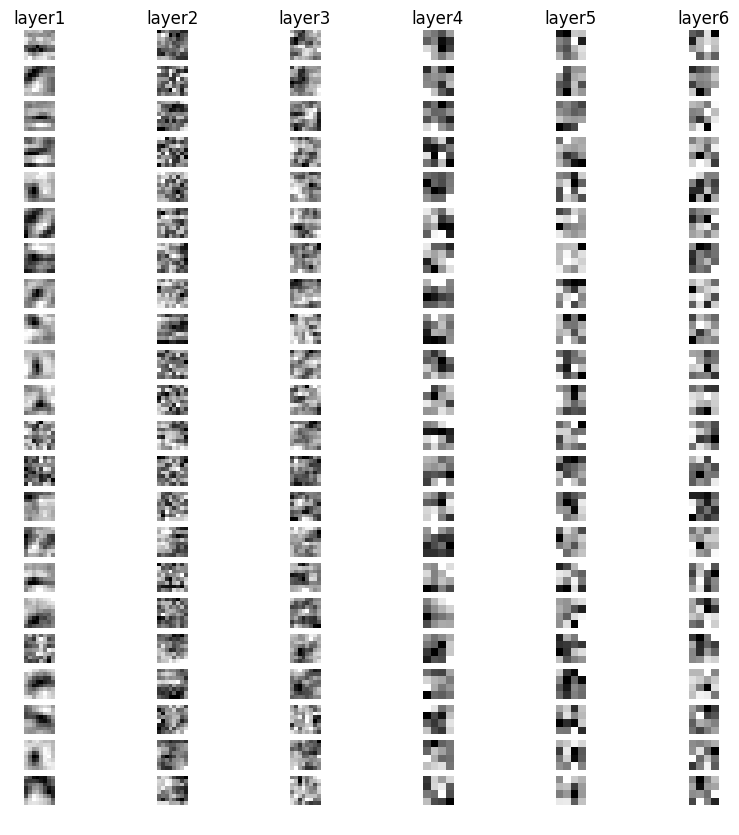

In [41]:
# calculating accuracy for each class separately for the test set
result_cnn, Wc1, Wc2, Wc3, Wc4, Wc5, Wc6 = sess.run([y, W_conv1, W_conv2, W_conv3, W_conv4, W_conv5, W_conv6], feed_dict = {xin: test_data,  keep_prob_input: 1.0})

#plotting extracted features (W)

filt13 = np.zeros([3,22, 8, 8]);
filt46 = np.zeros([3,22, 4, 4]);

for i in range(22):
    filt13[0,i,:,:] = Wc1[:,:,0,i];
    filt13[1,i,:,:] = Wc2[:,:,0,i];
    filt13[2,i,:,:] = Wc3[:,:,0,i];
    filt46[0,i,:,:] = Wc4[:,:,i,i];
    filt46[1,i,:,:] = Wc5[:,:,i,i];
    filt46[2,i,:,:] = Wc6[:,:,i,i];

plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
for i in range(0, 22):
    for j in range(0,3): 
        plt.subplot( 22, 6, 6*i+j+1)
        plt.imshow(filt13[j,i,:,:])
        plt.axis('off')
        if(i==0):
            plt.title('layer'+str(j+1))
        
        plt.subplot( 22, 6, 6*i+j+4)
        plt.imshow(filt46[j,i,:,:])
        plt.axis('off')
        if(i==0):
            plt.title('layer'+str(j+4))

# Feeding the  CNN with some data (camera/file)

Finally to test if the model really works it's needed to feed some new row and unlabeled data into the neural network.
To do so some images are taken from the internet or could be taken directly from the camera.

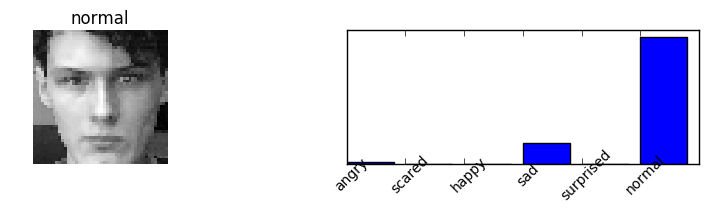

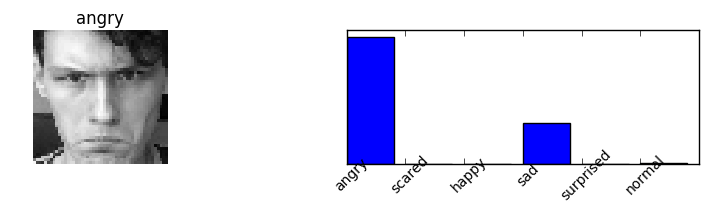

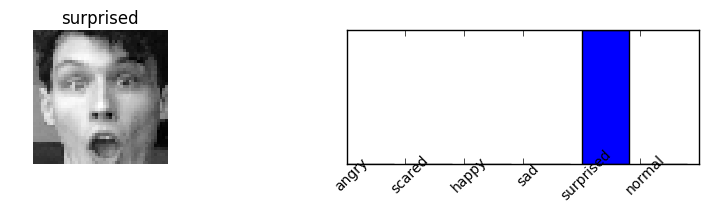

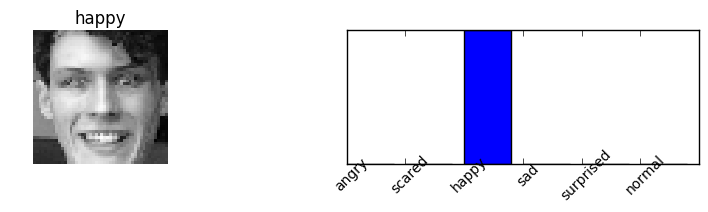

In [45]:
faces, marked_img = ut.get_faces_from_img('diff_emotions.jpg');
#faces, marked_img = ut.get_faces_from_img('big_bang.png');
#faces, marked_img = ut.get_faces_from_img('camera');

# if some face was found in the image
if(len(faces)):      
    #creating the blank test vector
    data_orig = np.zeros([n_train, 48,48])

    #putting face data into the vector (only first few)
    for i in range(0, len(faces)):
        data_orig[i,:,:] = ut.contrast_stretch(faces[i,:,:]);

        #preparing image and putting it into the batch 
        
        n = data_orig.shape[0];
        data = np.zeros([n,48**2])
        for i in range(n):
            xx = data_orig[i,:,:]
            xx -= np.mean(xx)
            xx /= np.linalg.norm(xx)
            data[i,:] = xx.reshape(2304); #np.reshape(xx,[-1])

    result = sess.run([y], feed_dict={xin: data, keep_prob_input: 1.0})
    
    plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
    for i in range(0, len(faces)):
        emotion_nr = np.argmax(result[0][i]);
        plt_idx = (2*i)+1;
        plt.subplot( 5, 2*len(faces)/5+1, plt_idx)
        plt.imshow(np.reshape(data[i,:], (48,48)))
        plt.axis('off')
        plt.title(str_emotions[emotion_nr])
        ax = plt.subplot(5, 2*len(faces)/5+1, plt_idx +1)
        ax.bar(np.arange(nc) , result[0][i])
        ax.set_xticklabels(str_emotions, rotation=45, rotation_mode="anchor")
        ax.set_yticks([])
        plt.show()
    

# Conclusions and comments
- The data contains a lot of noisy data, i.e. faces are rotated and of different size. 
- A lot of emotions in the dataset were labeled wrong. (e.g. happy images in sad images).
- (we think) That is why we couldn't achieve very good accuracy.
- The accuracy is very good for "Happy" and "Surprised" class. These images seems to be the most "clean" as data. 
- The computational power to train CNN is very high, therefore it was very time consuming to try different computational graphs.
- The facial emotion recognition is has very complicated features that were hard to explore for our computational graphs.

# Possible improvements in the future
- For sure the CNN would perfom better if the faces were always the same size and aligned straight. 
- We could try another, deeper CNN architectures to extract more features.


